# Introduction
This project aims to analyze the top 40 quarterbacks in the NFL based on four key metrics: Expected Points Added Per Play, Completion Percentage Over Expectation, Yards Per Play, and Touchdowns Per Play / Turnovers Per Play. Traditional stats such as passing touchdowns, total yards, and completion percentage can be misleading as they are very dependent on the situation, so these stats will hopefully provide a better analysis.

# Prep

In [61]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [62]:
#Configure DataFrame settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [63]:
# #Import data
# YEAR = 2020

# df = pd.read_csv(
#    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
#    + str(YEAR) + '.csv.gz?raw=True',compression='gzip', low_memory=False)

In [64]:
#Multiple seasons
YEARS = [2020,2019,2018,2017,2016,2014,2013,2012,2011,2010,2009,2008,2007,2006]

df = pd.DataFrame()

for i in YEARS:  
   i_data = pd.read_csv(
       'https://github.com/guga31bb/nflfastR-data/blob/' \
       'master/data/play_by_play_' + str(i) + '.csv.gz?raw=True',
       compression='gzip', low_memory=False
       )
 
df = df.append(i_data, sort=True)

In [65]:
#Clean up air_yards fields as recommended in tutorial
df["air_yards"] = np.where(df["air_yards"]<-10, df["air_yards"].median(), df["air_yards"])

In [66]:
#Store list of columns for future reference
cols = sorted(list(df.columns))

# Initialize DataFrame of QB ranks
This is the DataFrame I will use to rank the quarterbacks. Each QB will be assigned points for how they perform in the different statistics and then those points will be totaled to form a final ranking.

In [67]:
qb_rank = df[["name","pass_attempt"]].groupby("name").sum().sort_values("pass_attempt",ascending=False).head(50).sort_values("name")
qb_rank.reset_index(level=0, inplace=True)
qb_rank = qb_rank.drop("pass_attempt",axis=1)
qb_rank["epa_points"] = 0
qb_rank["cpoe_points"] = 0
qb_rank["ypp_points"] = 0
qb_rank["ratio_points"] = 0
qb_rank["total"] = 0
qb_rank

,name,epa_points,cpoe_points,ypp_points,ratio_points,total
0,A.Brooks,0,0,0,0,0
1,A.Smith,0,0,0,0,0
2,A.Walter,0,0,0,0,0
3,B.Favre,0,0,0,0,0
4,B.Gradkowski,0,0,0,0,0
...,...,...,...,...,...,...
45,T.Green,0,0,0,0,0
46,T.Jackson,0,0,0,0,0
47,T.Rattay,0,0,0,0,0
48,T.Romo,0,0,0,0,0


In [68]:
#Grab a list of the top 40 QBs by pass attempts
top_qbs = qb_rank["name"].tolist()

# Step 1: Ranking by EPA & CPOE

EPA - Expected Points Added: the average Expected Points Added per play in which an offensive player is directly involved. EPA/P is a measure of an individual player’s impact on the scores of his games, on a per play basis.

CPOE - Completion Percentage Over Expectation: the quarterback's actual completion percentage minus the expected completion percentage.

I am grouping these two together because they demonstrate the QB's ability to be accurate with their throws while also pushing the ball downfield to produce points.

In [69]:
#Create a dataframe of their average EPA and CPOE per play
qb_stat1 = df[df["name"].isin(top_qbs)][["name","epa","cpoe"]].groupby("name").mean()
qb_stat1.reset_index(level=0, inplace=True)
qb_stat1.head()

,name,epa,cpoe
0,A.Brooks,-0.260212,-2.023976
1,A.Smith,-0.079523,-0.833815
2,A.Walter,-0.333394,-6.165788
3,B.Favre,-0.054776,-5.356243
4,B.Gradkowski,-0.246883,-6.034457


Text(0, 0.5, 'Expected Points Added Per Play')

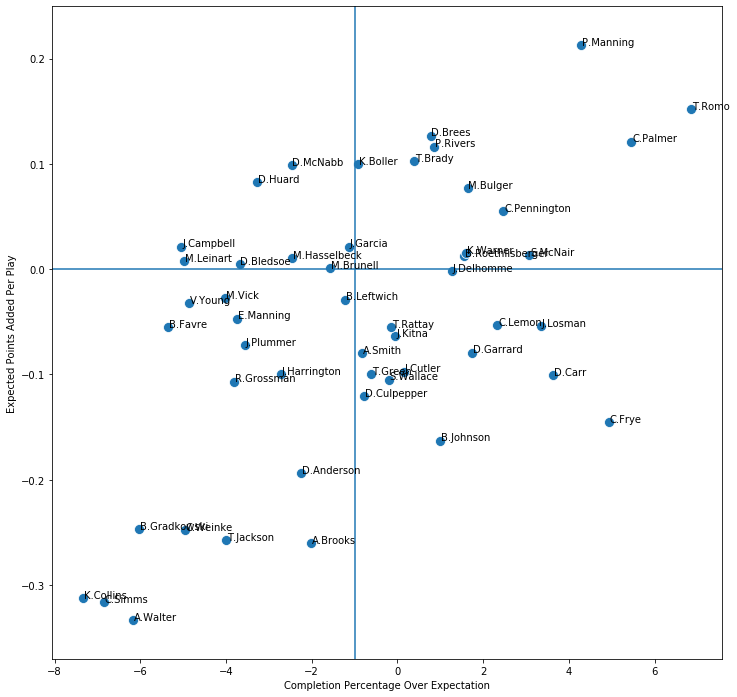

In [70]:
#Create scatterplot
plt.figure(figsize=(12,12))
g = sns.scatterplot(x="cpoe",y="epa",palette="Set1_r",data=qb_stat1,s=100)
g.axhline(0)
g.axvline(qb_stat1["cpoe"].mean())


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(qb_stat1.cpoe, qb_stat1.epa, qb_stat1.name, plt.gca())

plt.xlabel('Completion Percentage Over Expectation')
plt.ylabel('Expected Points Added Per Play')

## Analysis
Unsurprisingly, Peyton Manning and Tony Romo excel here. Carson Palmer, on the other hand, is a bit of a surprise

## Assign rankings
The best QB in a each statistic is given 40 points, the second best 39 points, etc.

In [71]:
qb_rank["epa_points"] = qb_stat1["epa"].rank(method="max")
qb_rank["cpoe_points"] = qb_stat1["cpoe"].rank(method="max")
qb_rank["total"] = qb_rank["epa_points"]+qb_rank["cpoe_points"]
qb_rank.sort_values("total",ascending=False)

,name,epa_points,cpoe_points,ypp_points,ratio_points,total
48,T.Romo,49.0,50.0,0,0,99.0
39,P.Manning,50.0,47.0,0,0,97.0
10,C.Palmer,47.0,49.0,0,0,96.0
11,C.Pennington,40.0,43.0,0,0,83.0
16,D.Brees,48.0,34.0,0,0,82.0
...,...,...,...,...,...,...
13,C.Weinke,6.0,8.0,0,0,14.0
4,B.Gradkowski,7.0,4.0,0,0,11.0
32,K.Collins,3.0,1.0,0,0,4.0
12,C.Simms,2.0,2.0,0,0,4.0


# Step 2: Ranking by YPP and TD/Turnover Ratio
YPP - Yards Per Play: the average pass or rush yards gained each play by the quarterback.

TD/Turnover Ratio: the average touchdowns scored each play divided by the average fumbles or interceptions each play. (Note: I include all fumbles, not just fumbles lost, because once fumbled it is primarily based on luch which team recovers.)

These statistics highlight the QB's ability to move the offense downfield, rack up touchdowns, and protect the football.

In [72]:
#Create a DataFrame that holds the YPP and TD/Turnover Ratio

qb_stat2 = df[df["name"].isin(top_qbs)][["name","pass_touchdown","rush_touchdown","fumble","interception","yards_gained"]].groupby("name").mean()
qb_stat2["td_rate"] = qb_stat2["pass_touchdown"]+qb_stat2["rush_touchdown"]
qb_stat2["trnvr_rate"] = qb_stat2["fumble"]+qb_stat2["interception"]
qb_stat2["ratio"] = qb_stat2["td_rate"]/qb_stat2["trnvr_rate"]
qb_stat2.reset_index(level=0, inplace=True)
qb_stat2.sort_values("ratio",ascending=False)

,name,pass_touchdown,rush_touchdown,fumble,interception,yards_gained,td_rate,trnvr_rate,ratio
9,C.Lemon,0.026667,0.000000,0.000000,0.013333,5.266667,0.026667,0.013333,2.000000
39,P.Manning,0.043423,0.006386,0.011494,0.020434,6.828863,0.049808,0.031928,1.560000
21,D.McNabb,0.045093,0.007958,0.018568,0.015915,7.119363,0.053050,0.034483,1.538462
35,M.Bulger,0.035294,0.000000,0.017647,0.011765,5.854412,0.035294,0.029412,1.200000
6,B.Leftwich,0.030973,0.008850,0.013274,0.022124,5.092920,0.039823,0.035398,1.125000
...,...,...,...,...,...,...,...,...,...
13,C.Weinke,0.017699,0.000000,0.017699,0.035398,5.185841,0.017699,0.053097,0.333333
12,C.Simms,0.008547,0.008547,0.000000,0.059829,4.786325,0.017094,0.059829,0.285714
0,A.Brooks,0.012000,0.000000,0.036000,0.032000,4.220000,0.012000,0.068000,0.176471
32,K.Collins,0.010309,0.000000,0.020619,0.061856,5.443299,0.010309,0.082474,0.125000


Text(0, 0.5, 'TDs/Turnovers Per Play')

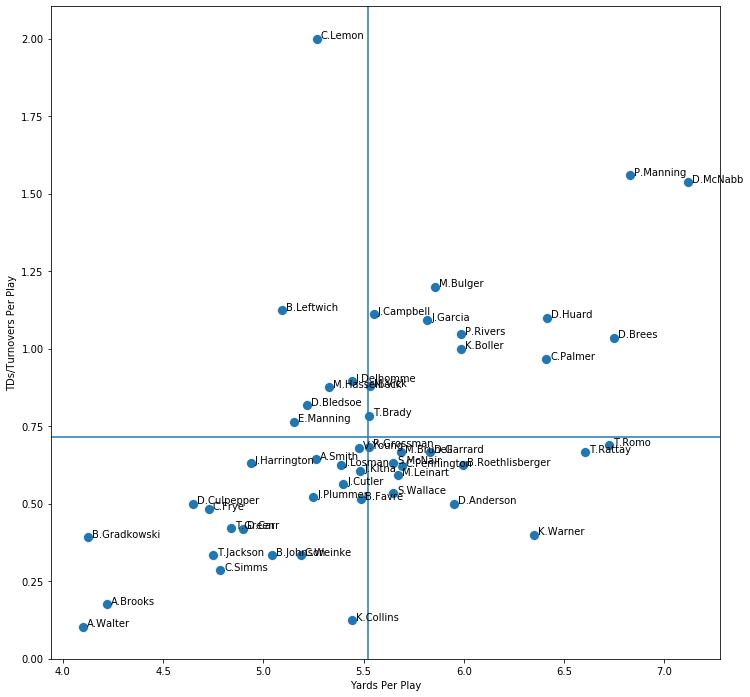

In [73]:
#Create scatterplot
plt.figure(figsize=(12,12))
g = sns.scatterplot(x="yards_gained",y="ratio",palette="Set1_r",data=qb_stat2,s=100)
g.axhline(qb_stat2["ratio"].mean())
g.axvline(qb_stat2["yards_gained"].mean())


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(qb_stat2.yards_gained, qb_stat2.ratio, qb_stat2.name, plt.gca()) 

plt.xlabel('Yards Per Play')
plt.ylabel('TDs/Turnovers Per Play')

## Analysis
Have a season, Aaron Rodgers! A hallmark of Rodgers' career has been producing touchdowns while avoiding turnovers, but it's striking to see him so much better than the next best QB in this statistic, Tua Tagovailoa (how about that for a surprise!). He takes care of the ball so well while also being among the leaders in YPP. Dak Prescott leads that category, but hasn't played a game since October due to injury. Of note: Tagovailoa has done a great job protecting the ball and producing touchdowns in his young career, but has been pulled from games due to his inability to generate yardage, where he is among the league's worst. Interestingly, his QB counterpart in Miami, Ryan Fitzpatrick, is the exact opposite, as he is nearly top-five in YPP but below average in taking care of the football.

## Assign rankings

In [74]:
qb_rank["ypp_points"] = qb_stat2["yards_gained"].rank(method="max")
qb_rank["ratio_points"] = qb_stat2["ratio"].rank(method="max")
qb_rank = qb_rank.drop("total",axis=1)
qb_rank["total"] = qb_rank["epa_points"]+qb_rank["cpoe_points"]+qb_rank["ypp_points"]+qb_rank["ratio_points"]
qb_rank.sort_values("total",ascending=False)

,name,epa_points,cpoe_points,ypp_points,ratio_points,total
39,P.Manning,50.0,47.0,49.0,49.0,195.0
10,C.Palmer,47.0,49.0,44.0,39.0,179.0
48,T.Romo,49.0,50.0,47.0,32.0,178.0
16,D.Brees,48.0,34.0,48.0,41.0,171.0
35,M.Bulger,41.0,40.0,38.0,47.0,166.0
...,...,...,...,...,...,...
32,K.Collins,3.0,1.0,23.0,2.0,29.0
46,T.Jackson,5.0,11.0,6.0,6.0,28.0
4,B.Gradkowski,7.0,4.0,2.0,8.0,21.0
12,C.Simms,2.0,2.0,7.0,4.0,15.0


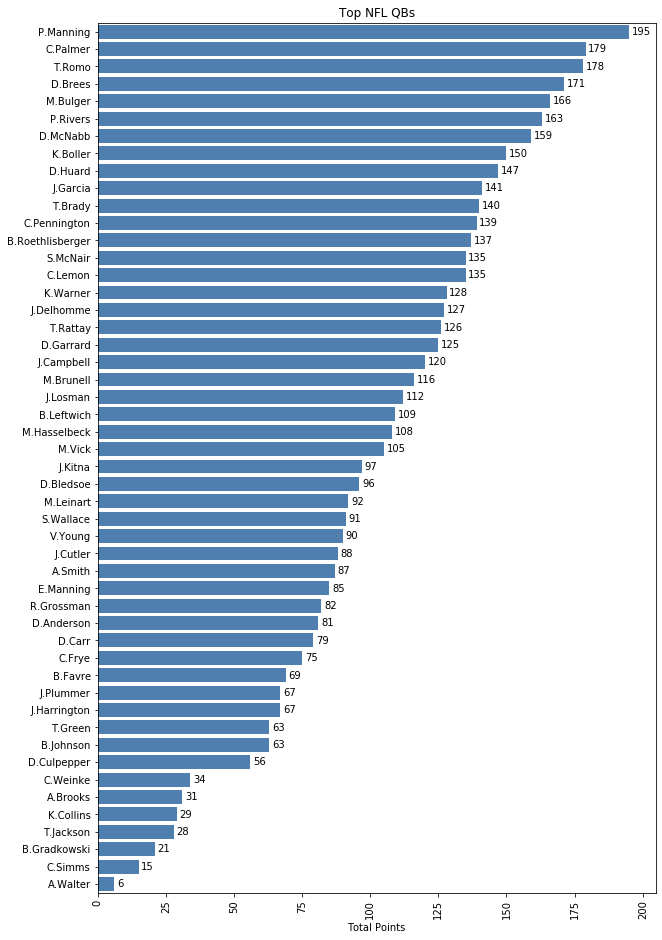

In [75]:
#Create horizontal bar chart to visualize final rankings
ranked_qb_list = list(qb_rank.sort_values("total",ascending=False)["name"])

fig, ax = plt.subplots(figsize=(10,16))
graph = sns.barplot(x="total",y="name",data=qb_rank,order=ranked_qb_list,color="#3F7FBF")

plt.xlabel("Total Points")
plt.ylabel("")
plt.title("Top NFL QBs")


for item in graph.get_xticklabels():
    item.set_rotation(90)
    
totals = qb_rank["total"].sort_values(ascending=False).astype(np.int64)
for i, v in enumerate(totals):
    ax.text(v + 1, i, str(v), color='black', fontweight='normal', fontsize=10, ha='left', va='center')

## Analysis
According to these statistics, Aaron Rodgers is far and away the 2020 MVP as he pilots the Green Bay Packers into a possible #1 seed in the NFC. Pat Mahomes comes in second but surprisingly is trailed very closely by Deshaun Watson who is having the best season of his career despite being surrounded by terrible talent. Tom Brady and Ryan Fitzpatrick are having career resurgences, while Cam Newton looks like he may have exited his prime for good. And as for Dwayne Haskins; well, let's just hope that Ohio State degree will get him a steady job.